# ▶️ CUDA setup

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [7]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


GPU computing notebooks download (from github)

In [8]:
!git clone https://github.com/giulianogrossi/GPUcomputing.git

fatal: destination path 'GPUcomputing' already exists and is not an empty directory.


NVCC Plugin for Jupyter notebook

In [9]:
%cd GPUcomputing/utils/nvcc4jupyter-master/
!python3 -m build
%load_ext nvcc4jupyter
%cd /content/

/content/GPUcomputing/utils/nvcc4jupyter-master
* Creating isolated environment: venv+pip...
* Installing packages in isolated environment:
  - setuptools >= 40.8.0
* Getting build dependencies for sdist...
running egg_info
writing nvcc4jupyter.egg-info/PKG-INFO
writing dependency_links to nvcc4jupyter.egg-info/dependency_links.txt
writing top-level names to nvcc4jupyter.egg-info/top_level.txt
reading manifest file 'nvcc4jupyter.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'nvcc4jupyter.egg-info/SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing nvcc4jupyter.egg-info/PKG-INFO
writing dependency_links to nvcc4jupyter.egg-info/dependency_links.txt
writing top-level names to nvcc4jupyter.egg-info/top_level.txt
reading manifest file 'nvcc4jupyter.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'nvcc4jupyter.egg-info/SOURCES.txt'

running check
creating nvcc4jupyter-0.1.0
creating nvcc4jupyter-0.1.0/nvcc4jupyter
cre

# ▶️ DeviceQuery

In [ ]:
# DeviceQuery dell'attuale device (su Colab!)
!nvcc -arch=sm_75 /content/GPUcomputing/utils/deviceQuery.cu -o deviceQuery
!./deviceQuery


CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla T4"
  CUDA Driver Version / Runtime Version          12.2 / 12.2
  GPU arch name:                                 Turing
  CUDA Capability Major/Minor version number:    7.5
  Total amount of global memory:                 15102 MBytes (15835660288 bytes)
  (40) Multiprocessors, ( 64) CUDA Cores/MP:     2560 CUDA Cores
  GPU Max Clock rate:                            1590 MHz (1.59 GHz)
  Memory Clock rate:                             5001 Mhz
  Memory Bus Width:                              256-bit
  L2 Cache Size:                                 4194304 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory                65536

# ✅ PROGETTO


## 🔵 Data Generation


### CUDA


In [5]:
%%cuda_group_save --name "dataGeneration.cu" --group "PRJ"
#include <stdio.h>
#include <stdlib.h>
#include "../../GPUcomputing/utils/common.h"
#include <curand.h>
#include <curand_kernel.h>
#include <time.h>
#include <float.h>

//coordinata x e y massima [-10000 - radius, 10000 + radius]
#define MAX_X 10000
#define MAX_Y 10000


// Struttura per rappresentare un punto
typedef struct Points {
    float x;
    float y;
} Point;



__global__ void generatePointsGPU(Point* points, Point* roots, int nPoints, int nRoots, float radius, unsigned long seed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < nPoints) {

        curandState state;
        curand_init(seed, idx, 0, &state);

        //Seleziona casualmente un punto radice
        int root_idx = curand(&state) % nRoots;
        Point root = roots[root_idx];

        //Genera un angolo casuale
        float angle = curand_uniform(&state) * 2.0f * M_PI;

        //Genera una distanza casuale dal punto radice usando una distribuzione normale
        float distance = curand_normal(&state) * (radius/3 );


        //Calcola la posizione del nuovo punto
        points[idx].x = root.x + distance * cosf(angle);
        points[idx].y = root.y + distance * sinf(angle);
    }
}

void generatePointsCPU(Point* points, Point* roots, int nPoints, int nRoots, float radius) {
    for (int i = 0; i < nPoints; i++) {
        //Seleziona casualmente un punto radice
        int root_idx = rand() % nRoots;
        Point root = roots[root_idx];

        //Genera un angolo casuale
        float u1 = (float)rand() / (float)RAND_MAX;
        float angle = u1 * 2.0f * M_PI;

        //Genera una distanza casuale dal punto radice usando una distribuzione normale
        //BOX-MULLER
        float u2 = (float)rand() / (float)RAND_MAX;
        float u3 = (float)rand() / (float)RAND_MAX;
        float z = sqrt(-2.0f * log(u2)) * cos(2.0f * M_PI * u3);
        float distance = fabs(z) * (radius / 3.0f);


        points[i].x = root.x + distance * cosf(angle);
        points[i].y = root.y + distance * sinf(angle);
    }
}

void generateRandomCentroids(Point *centroids, int k) {
     // Inizializza il generatore di numeri casuali
    for (int i = 0; i < k; i++) {
        centroids[i].x = ((float)rand() / RAND_MAX) * 2 * MAX_X - MAX_X;
        centroids[i].y = ((float)rand() / RAND_MAX) * 2 * MAX_Y - MAX_Y;
    }
}


void writePoints(Point* points,int nPoints,const char* path) {
    FILE *file;
    file = fopen(path, "w");

    if (file) {
        printf("Stampo file\n");
        for (int i = 0; i < nPoints; ++i) {
            fprintf(file, "%f,%f\n", points[i].x, points[i].y);
        }
        fclose(file);
    } else {
        printf("Errore nell'apertura del file\n");
    }
}


int main() {

    double start, end;

    const int nPoints = 1000*1000; // Numero di punti da generare
    const int nRoots = 20; // Numero di punti radice
    const float radius = 1400.0f; // Raggio di distribuzione intorno ai punti radice

    //unsigned long int seed = time(NULL);
    unsigned long int seed = 42;
    srand(seed);

    //Alloco memoria per i punti e i punti radice
    Point* d_points;
    Point* d_roots;
    Point h_points[nPoints];
    cudaMalloc(&d_points, nPoints * sizeof(Point));
    cudaMalloc(&d_roots, nRoots * sizeof(Point));



    //h_roots viene usata sia per GPU che per CPU
    Point h_roots[nRoots];


    //Array per i punti CPU
    Point* points = (Point* ) malloc(nPoints * sizeof(Point));


    //Genera dei centroidi che vengono usati come root per i cluster
    generateRandomCentroids(h_roots, nRoots);

    /***********************************************************/
	/*                     CPU generation                      */
	/***********************************************************/
    printf("****************************\n");
    printf("CPU generation\n");
    printf("****************************\n");

    srand(seed);
    start = seconds();
    generatePointsCPU(points, h_roots, nPoints, nRoots, radius);
    end = seconds();

    double CPUtime = end - start;
    printf("Tempo di esecuzione CPU: %f\n", CPUtime);
    writePoints(points, nPoints, "src/PRJ/points_CPU.csv");

    free(points);

    printf("\n\n");
    /***********************************************************/
	/*                     GPU generation                      */
	/***********************************************************/
    printf("****************************\n");
    printf("GPU generation\n");
    printf("****************************\n");
    //Root da host a device
    cudaMemcpy(d_roots, h_roots, nRoots * sizeof(Point), cudaMemcpyHostToDevice);
    //Config il kernel
    int blockSize = 64;
    int numBlocks = (nPoints + blockSize - 1) / blockSize;

    start = seconds();
    generatePointsGPU<<<numBlocks, blockSize>>>(d_points, d_roots, nPoints, nRoots, radius, seed);
    cudaDeviceSynchronize();
    end = seconds();

    double GPUtime = end - start;
    printf("Tempo di esecuzione GPU: %f\n",GPUtime);
	double speedup = CPUtime/GPUtime;
	printf("    Speedup %.1f\n", speedup);

    //Risultato da device a host

    cudaMemcpy(h_points, d_points, nPoints * sizeof(Point), cudaMemcpyDeviceToHost);
    writePoints(h_points, nPoints, "src/PRJ/points_GPU.csv");


    cudaFree(d_points);
    cudaFree(d_roots);

    return 0;
}


In [ ]:
!nvcc -arch=sm_75 src/PRJ/dataGeneration.cu -o dataGeneration
!./dataGeneration

****************************
CPU generation
****************************
Tempo di esecuzione CPU: 0.114731
Stampo file


****************************
GPU generation
****************************
Tempo di esecuzione GPU: 0.041675
    Speedup 2.8
Stampo file


### Profiling


In [ ]:
!ncu dataGeneration
!ncu -o dataGeneration_profile dataGeneration


==PROF== Connected to process 7924 (/content/dataGeneration)
****************************
CPU generation
****************************
Tempo di esecuzione CPU: 0.188083
Stampo file


****************************
GPU generation
****************************
==PROF== Profiling "generatePointsGPU" - 0: 0%....50%....100% - 8 passes
Tempo di esecuzione GPU: 0.796188
    Speedup 0.2
Stampo file
==PROF== Disconnected from process 7924
[7924] dataGeneration@127.0.0.1
  generatePointsGPU(Points *, Points *, int, int, float, unsigned long) (15625, 1, 1)x(64, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: GPU Speed Of Light Throughput
    ----------------------- ------------- ------------
    Metric Name               Metric Unit Metric Value
    ----------------------- ------------- ------------
    DRAM Frequency          cycle/nsecond         4.99
    SM Frequency            cycle/usecond       584.35
    Elapsed Cycles                  cycle   23,861,514
    Memory Throughput        

### Plotting

1000000


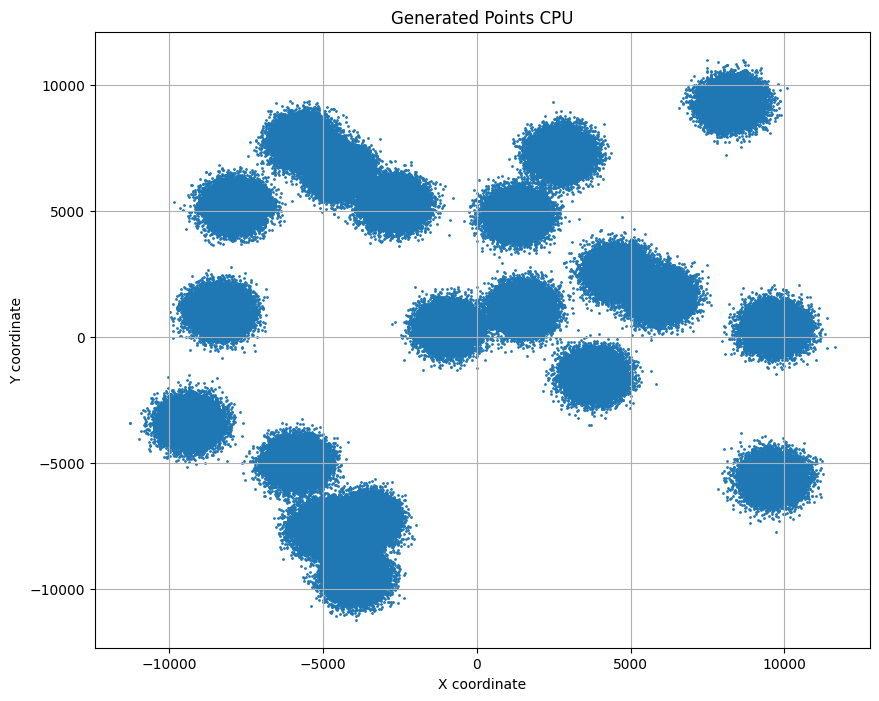

1000000


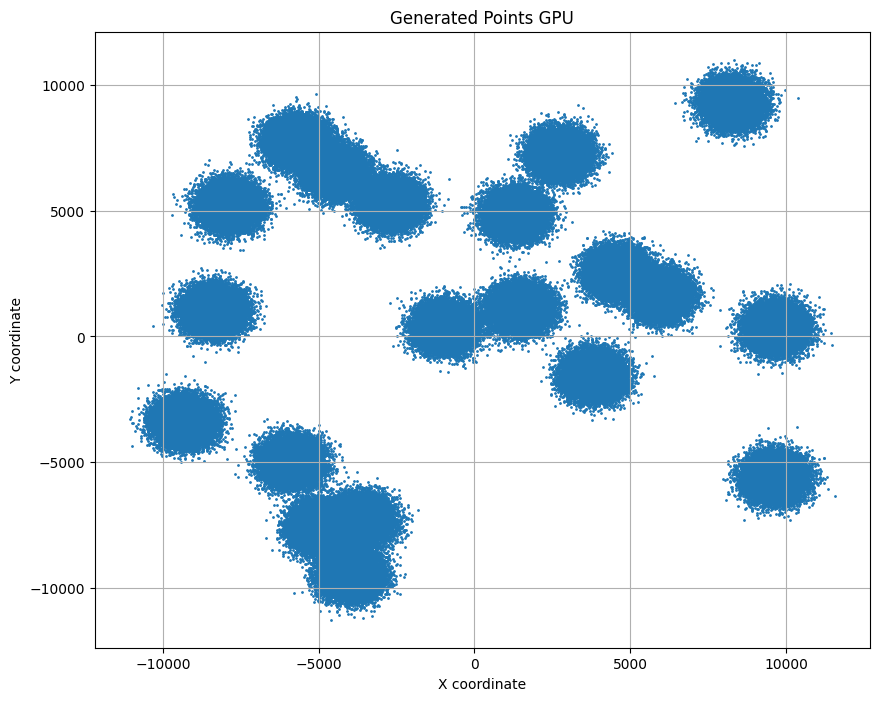

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Legge il file CSV
df = pd.read_csv('src/PRJ/points_CPU.csv', header=None, names=['x', 'y'])

print(len(df['x']))

# Plot dei punti
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], s=1)
plt.title('Generated Points CPU')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.show()

# Legge il file CSV
df = pd.read_csv('src/PRJ/points_GPU.csv', header=None, names=['x', 'y'])

print(len(df['x']))

# Plot dei punti
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], s=1)
plt.title('Generated Points GPU')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.show()


## 🔵 Clustering

### CUDA

In [10]:
%%cuda_group_save --name "clustering.cu" --group "PRJ"
#include <stdio.h>
#include <stdlib.h>
#include "../../GPUcomputing/utils/common.h"
#include <curand.h>
#include <curand_kernel.h>
#include <time.h>
#include <float.h>

//coordinata x e y massima [-1000 - radius, 1000 + radius]
#define MAX_X 10000
#define MAX_Y 10000


typedef struct {
    float x;
    float y;
} Point;

void readPoints(const char* path, Point* points) {
    FILE *file;
    file = fopen(path, "r");
    if (file) {
      char line[256];
      float x, y;
      int i = 0;
      while (fgets(line, sizeof(line), file)) {
        // Parse the line to extract two floats
        if (sscanf(line, "%f,%f", &x, &y) == 2) {
            // Process the extracted numbers
            points[i].x = x;
            points[i].y = y;
        } else {
            fprintf(stderr, "Error parsing line: %s", line);
        }
        i++;
      }

    }else{
        printf("Errore nell'apertura del file\n");
    }
}


void generateRandomCentroids(Point *centroids, int k) {
    srand(time(NULL)); // Inizializza il generatore di numeri casuali
    for (int i = 0; i < k; i++) {
        centroids[i].x = ((float)rand() / RAND_MAX) * 2 * MAX_X - MAX_X;
        centroids[i].y = ((float)rand() / RAND_MAX) * 2 * MAX_Y - MAX_Y;
    }
}

void deepCopyPoints(Point* dest, Point* src, int nCluster) {
    for (int i = 0; i < nCluster; ++i) {
        dest[i] = src[i];

    }
}


float distance(Point a, Point b) {
    return sqrt((a.x - b.x) * (a.x - b.x) + (a.y - b.y) * (a.y - b.y));
}

void kmeansCPU(Point *points, int num_points, Point *centroids, int num_centroids, int *labels) {
    int changed;
    Point *new_centroids = (Point *)malloc(num_centroids * sizeof(Point));
    int *counts = (int *)malloc(num_centroids * sizeof(int));

    do {
        //Reset dei centroidi
        for (int i = 0; i < num_centroids; i++) {
            new_centroids[i].x = 0;
            new_centroids[i].y = 0;
            counts[i] = 0;
        }

        changed = 0;

        //Assegno ad ogni punto il centroide più vicino
        for (int i = 0; i < num_points; i++) {
            float min_dist = FLT_MAX;
            int closest_centroid = 0;
            for (int j = 0; j < num_centroids; j++) {
                float dist = distance(points[i], centroids[j]);
                if (dist < min_dist) {
                    min_dist = dist;
                    closest_centroid = j;
                }
            }
            //Stopping criteria
            if (labels[i] != closest_centroid) {
                labels[i] = closest_centroid;
                changed = 1;
            }
            new_centroids[closest_centroid].x += points[i].x;
            new_centroids[closest_centroid].y += points[i].y;
            counts[closest_centroid]++;
        }

        // Recalculate centroids
        for (int i = 0; i < num_centroids; i++) {
            if (counts[i] != 0) {
                centroids[i].x = new_centroids[i].x / counts[i];
                centroids[i].y = new_centroids[i].y / counts[i];
            }
        }

    } while (changed);

    free(new_centroids);
    free(counts);
}

void writePointsV2(Point *points,int* labels, int nPoints,const char* path) {
    FILE *file;
    file = fopen(path, "w");

    if (file) {
        printf("Stampo file\n");
        for (int i = 0; i < nPoints; ++i) {
            fprintf(file, "%f,%f,%d\n", points[i].x, points[i].y, labels[i]);
        }
        fclose(file);
    } else {
        printf("Errore nell'apertura del file\n");
    }
}

__global__ void kmeansSumPoints(Point* points, Point* centroids, int* labels, int* count, Point* sum_points, int nPoints, int n_centroids, int* d_changed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < nPoints) {
        int closestCentroid = -1;
        float minDistance = FLT_MAX;
        float distance = 0.0f;
        for (int i = 0; i < n_centroids; i++) {
            distance = sqrtf((points[idx].x - centroids[i].x) * (points[idx].x - centroids[i].x) + (points[idx].y - centroids[i].y) * (points[idx].y - centroids[i].y));
            if (distance < minDistance) {
                minDistance = distance;
                closestCentroid = i;
            }
        }
        if (labels[idx] != closestCentroid) {
            labels[idx] = closestCentroid;
            atomicAdd(d_changed, 1);
        }
        atomicAdd(&sum_points[closestCentroid].x, points[idx].x);
        atomicAdd(&sum_points[closestCentroid].y, points[idx].y);
        atomicAdd(&count[closestCentroid], 1);
    }
}

__global__ void kmeansUpdateCentroids(Point* centroids, Point* sum_points, int* count, int n_centroids) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_centroids) {
        if (count[idx] > 0) {
            centroids[idx].x = sum_points[idx].x / count[idx];
            centroids[idx].y = sum_points[idx].y / count[idx];
        }
    }
}

int main() {
    double start, end;

    double endNoTransf, endTransf;

    const int nCluster = 12;

    const int nPoints = 1000*1000; // Numero di punti da generare

    //unsigned long int seed = time(NULL);
    unsigned long int seed = 42;
    srand(seed);


    //punti CPU
    Point* points;
    points = (Point* )malloc(nPoints * sizeof(Point));
    readPoints("src/PRJ/points_CPU.csv", points);


    Point* centroids = (Point* )malloc(nCluster * sizeof(Point));
    generateRandomCentroids(centroids, nCluster);

    //Utilizzo gli stessi centroidi per entrambi i metodi
    Point* h_centroids = (Point* )malloc(nCluster * sizeof(Point));
    deepCopyPoints(h_centroids, centroids, nCluster);

    int labelsSEQ[nPoints];

    /***********************************************************/
	/*                     CPU clustering                      */
	/***********************************************************/
    start = seconds();
    kmeansCPU(points, nPoints, centroids, nCluster, labelsSEQ);
    end = seconds();
    double CPUtime = end - start;
    printf("Tempo di esecuzione CPU: %f\n",CPUtime);

    writePointsV2(points, labelsSEQ, nPoints, "src/PRJ/clusteredPoints_CPU.csv");
    free(points);
    /***********************************************************/
	/*                     GPU clustering                      */
	/***********************************************************/


    Point *h_points;
    h_points = (Point* )malloc(nPoints * sizeof(Point));
    readPoints("src/PRJ/points_CPU.csv", h_points);

    Point *d_points;
    cudaMalloc(&d_points, nPoints * sizeof(Point));

    cudaMemcpy(d_points, h_points, nPoints * sizeof(Point), cudaMemcpyHostToDevice);


    //generazione centroidi
    Point* d_centroids;
    cudaMalloc(&d_centroids, nCluster * sizeof(Point));

    //trasferimento centroidi da host a device
    cudaMemcpy(d_centroids, h_centroids, nCluster * sizeof(Point), cudaMemcpyHostToDevice);

    //generazione array label trasferimento non necessario
    int* h_labelsPARALLEL = (int* ) malloc(nPoints * sizeof(int));

    int* d_labelsPARALLEL;
    cudaMalloc(&d_labelsPARALLEL, nPoints * sizeof(int));
    cudaMemset(d_labelsPARALLEL, 0, nPoints * sizeof(int)); // Inizializza a zero

    //generazione array count
    int* d_count;
    cudaMalloc(&d_count, nCluster * sizeof(int));
    cudaMemset(d_count, 0, nCluster * sizeof(int)); // Inizializza a zero

    //generazione array sum_points
    Point* d_sum_points;
    cudaMalloc(&d_sum_points, nCluster * sizeof(Point));
    cudaMemset(d_sum_points, 0, nCluster * sizeof(Point)); // Inizializza a zero

    //creazione della variabile d_changed
    int* d_changed;
    cudaMalloc(&d_changed, sizeof(int));

    int blockSize = 64;
    int numBlocks = (nPoints + blockSize - 1) / blockSize;
    start = seconds();
    //print first d_centroids
    printf("%f, %f\n", h_centroids[0].x, h_centroids[0].y);
    do {
        cudaMemset(d_changed, 0, sizeof(int)); // Resetta changed
        //Primo passo: sommare i punti assegnati
        kmeansSumPoints<<<numBlocks, blockSize>>>(d_points, d_centroids, d_labelsPARALLEL, d_count, d_sum_points, nPoints, nCluster, d_changed);
        cudaDeviceSynchronize();

        //Secondo passo: calcolare le nuove coordinate dei centroidi
        kmeansUpdateCentroids<<<1, nCluster>>>(d_centroids, d_sum_points, d_count, nCluster);
        cudaDeviceSynchronize();

        cudaMemset(d_sum_points, 0, nCluster * sizeof(Point)); // Resetta sum_points
        cudaMemset(d_count, 0, nCluster * sizeof(int)); // Resetta count
        cudaMemcpy(h_centroids, d_centroids, nCluster * sizeof(Point), cudaMemcpyDeviceToHost);

        int h_changed;
        cudaMemcpy(&h_changed, d_changed, sizeof(int), cudaMemcpyDeviceToHost);
        if (h_changed == 0) break;

    } while (true);
    printf("%f, %f\n", h_centroids[0].x, h_centroids[0].y);
    endNoTransf = seconds();
    // Copia dei risultati da device a host
    cudaMemcpy(h_points, d_points, nPoints * sizeof(Point), cudaMemcpyDeviceToHost);
    cudaMemcpy(h_labelsPARALLEL, d_labelsPARALLEL, nPoints * sizeof(int), cudaMemcpyDeviceToHost);

    endTransf = seconds();
    double GPUtimeNoTransf = endNoTransf - start;
    double GPUtimeTransf = endTransf - start;
    printf("Tempo di esecuzione GPU (NO Transfer): %f\n",GPUtimeNoTransf);
	  double speedupNoTransf = CPUtime/GPUtimeNoTransf;
	  printf("    Speedup (NO transfer) %.1f\n", speedupNoTransf);

    printf("Tempo di esecuzione GPU (with Transfer): %f\n",GPUtimeTransf);
	  double speedupTransf = CPUtime/GPUtimeTransf;
	  printf("    Speedup (with transfer) %.1f\n", speedupTransf);



    // Scrittura dei risultati su file
    writePointsV2(h_points, h_labelsPARALLEL, nPoints, "src/PRJ/clusteredPoints_GPU.csv");

    // Cleanup
    cudaFree(d_points);

    cudaFree(d_centroids);
    cudaFree(d_labelsPARALLEL);
    cudaFree(d_count);
    cudaFree(d_sum_points);
    cudaFree(d_changed);
    free(h_labelsPARALLEL);

    return 0;
}


In [ ]:
!nvcc -arch=sm_75 src/PRJ/clustering.cu -o clustering
!./clustering

Tempo di esecuzione CPU: 1.294157
Stampo file
-4262.636719, 1806.800781
-8117.269531, 3123.375732
Tempo di esecuzione GPU (NO Transfer): 0.017307
    Speedup (NO transfer) 74.8
Tempo di esecuzione GPU (with Transfer): 0.021848
    Speedup (with transfer) 59.2
Stampo file


###  Plotting

Number of points: 1000000


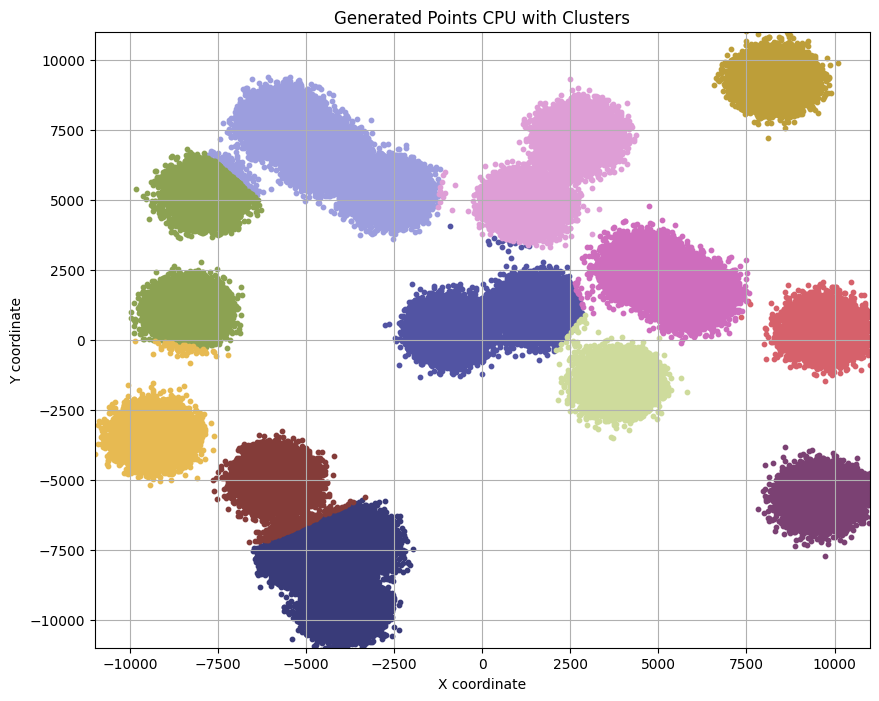

Number of points: 1000000


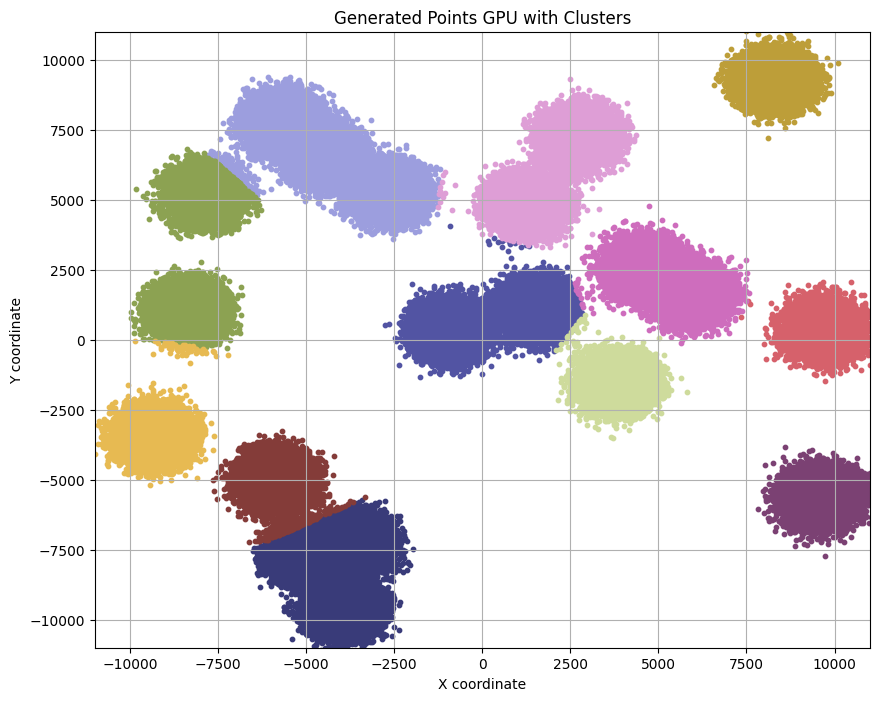

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#===============================================================================
#======================CPU PLOTTING=============================================
#===============================================================================
df = pd.read_csv('src/PRJ/clusteredPoints_CPU.csv', header=None, names=['x', 'y', 'label'])

print(f"Number of points: {len(df)}")

unique_labels = df['label'].unique()

colors = plt.colormaps['tab20b'].resampled(len(unique_labels))

#Crea una mappa per i colori dei cluster
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}


plt.figure(figsize=(10, 8))

#PEr problema con colori doppioni
for label in unique_labels:
    cluster_points = df[df['label'] == label]
    plt.scatter(cluster_points['x'], cluster_points['y'], s=10, label=f'Cluster {label}', color=color_map[label])

plt.xlim(-11000, 11000)
plt.ylim(-11000, 11000)

plt.title('Generated Points CPU with Clusters')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)

plt.show()

#===============================================================================
#======================GPU PLOTTING=============================================
#===============================================================================

df = pd.read_csv('src/PRJ/clusteredPoints_GPU.csv', header=None, names=['x', 'y', 'label'])

print(f"Number of points: {len(df)}")

unique_labels = df['label'].unique()

colors = plt.colormaps['tab20b'].resampled(len(unique_labels))

color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

plt.figure(figsize=(10, 8))

for label in unique_labels:
    cluster_points = df[df['label'] == label]
    plt.scatter(cluster_points['x'], cluster_points['y'], s=10, label=f'Cluster {label}', color=color_map[label])

plt.xlim(-11000, 11000)
plt.ylim(-11000, 11000)

plt.title('Generated Points GPU with Clusters')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)

plt.show()

### Profiling

In [ ]:
!ncu clustering
!ncu -o clustering_profile clustering

Tempo di esecuzione CPU: 1.990529
Stampo file
==PROF== Connected to process 8047 (/content/clustering)
-3673.349121, -8988.791016
==PROF== Profiling "kmeansSumPoints" - 0: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansUpdateCentroids" - 1: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansSumPoints" - 2: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansUpdateCentroids" - 3: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansSumPoints" - 4: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansUpdateCentroids" - 5: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansSumPoints" - 6: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansUpdateCentroids" - 7: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansSumPoints" - 8: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansUpdateCentroids" - 9: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansSumPoints" - 10: 0%....50%....100% - 8 passes
==PROF== Profiling "kmeansUpdateCentroids" - 11: 0%....50%